In [1]:
# Enable Float64 for more stable matrix inversions.
from jax.config import config

config.update("jax_enable_x64", True)

from jax import jit
import jax.numpy as jnp
import jax.random as jr
from jaxtyping import install_import_hook
import matplotlib as mpl
import matplotlib.pyplot as plt
import optax as ox
from docs.examples.utils import clean_legend

with install_import_hook("gpjax", "beartype.beartype"):
    import gpjax as gpx

key = jr.PRNGKey(123)
plt.style.use("./gpjax.mplstyle")
cols = mpl.rcParams["axes.prop_cycle"].by_key()["color"]

In [2]:
x = jr.uniform(key=key, minval=0, maxval=1, shape=(20, 1))
y = jnp.full((20, 1), 50, dtype=jnp.float64)
D = gpx.Dataset(X=x, y=y)

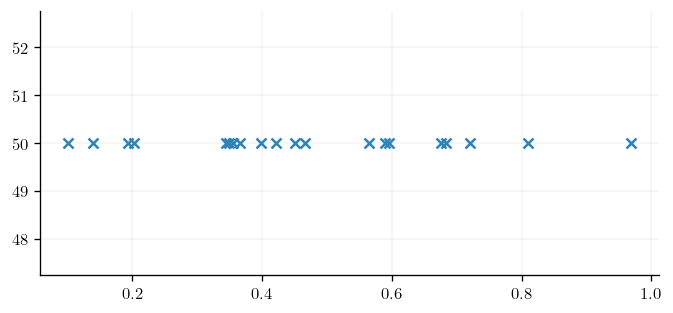

In [3]:
plt.scatter(x, y)

In [4]:
kernel = gpx.kernels.Matern52()
meanf = gpx.mean_functions.Zero()
prior = gpx.Prior(mean_function=meanf, kernel=kernel)

In [5]:
prior_dist = prior.predict(x)
prior_mean = prior_dist.mean()

In [6]:
likelihood = gpx.Gaussian(num_datapoints=D.n)
likelihood = gpx.Gaussian(
    num_datapoints=D.n, obs_noise=jnp.array(1e-6)
)  # Our function is noise-free, so we set the observation noise to a very small value
likelihood = likelihood.replace_trainable(obs_noise=False)

In [7]:
posterior = prior * likelihood

In [8]:
negative_mll = gpx.objectives.ConjugateMLL(negative=True)
negative_mll(posterior, train_data=D)

Array(1719.45465439, dtype=float64)

In [9]:
negative_mll = jit(negative_mll)

In [10]:
opt_posterior, history = gpx.fit(
    model=posterior,
    objective=negative_mll,
    train_data=D,
    optim=ox.adam(learning_rate=0.01),
    num_iters=2000,
    safe=True,
    key=key,
)

  0%|          | 0/2000 [00:00<?, ?it/s]

In [11]:
opt_posterior

ConjugatePosterior(prior=Prior(kernel=Matern52(compute_engine=DenseKernelComputation(), active_dims=None, name='Matérn52', lengthscale=Array(5.40475255, dtype=float64), variance=Array(7.10042424, dtype=float64)), mean_function=Zero(constant=Array([0.], dtype=float64)), jitter=1e-06), likelihood=Gaussian(num_datapoints=20, integrator=AnalyticalGaussianIntegrator(), obs_noise=Array(1.e-06, dtype=float64)), jitter=1e-06)

In [15]:
assert(opt_posterior.prior.mean_function.constant == 0.0)

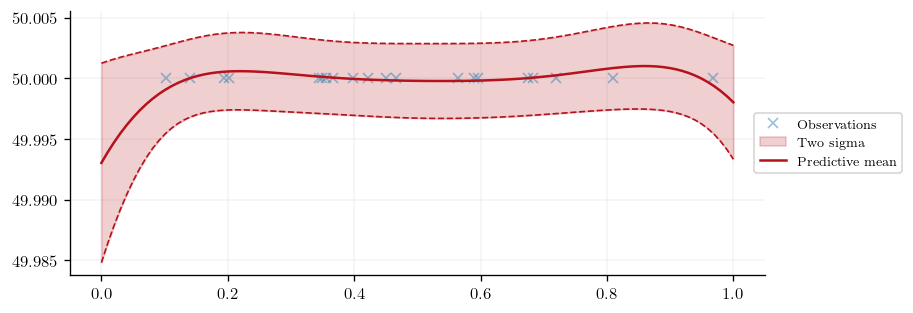

In [12]:
xtest = jnp.linspace(0, 1, 100).reshape(-1, 1)

latent_dist = opt_posterior.predict(xtest, train_data=D)
predictive_dist = opt_posterior.likelihood(latent_dist)

predictive_mean = predictive_dist.mean()
predictive_std = predictive_dist.stddev()

fig, ax = plt.subplots(figsize=(7.5, 2.5))
ax.plot(x, y, "x", label="Observations", color=cols[0], alpha=0.5)
ax.fill_between(
    xtest.squeeze(),
    predictive_mean - 2 * predictive_std,
    predictive_mean + 2 * predictive_std,
    alpha=0.2,
    label="Two sigma",
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean - 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
ax.plot(
    xtest,
    predictive_mean + 2 * predictive_std,
    linestyle="--",
    linewidth=1,
    color=cols[1],
)
# ax.plot(
#     xtest, ytest, label="Latent function", color=cols[0], linestyle="--", linewidth=2
# )
ax.plot(xtest, predictive_mean, label="Predictive mean", color=cols[1])
ax.legend(loc="center left", bbox_to_anchor=(0.975, 0.5))